# SETUP

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from epiml.loadepiml import LoadEpiml, save_search, load_search
from epiml.epimlsklearn.epimlmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from epiml.semisuperhelper import SemiSupervisedHelper
from epiml.epimlsklearn.pnuwrapper import PNUWrapper
from epiml.epimlsklearn.jsearchcv import JRandomSearchCV, extract_score_grid
from epiml.epimlsklearn.nestedcross import NestedCV, rerun_nested_for_estimator, rerun_nested_for_scoring
from epiml.epimlsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested

In [3]:
path = "C:\Data\membership14_final_0103.txt"
lc = LoadEpiml(path)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.model_selection import validation_curve

In [5]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

# Set up PNU Wrapper with Random Forest

In [6]:
pnu = PNUWrapper(base_estimator=RandomForestClassifier(), random_state=337)

### Put in params that are decent

In [7]:
params = {'base_estimator__class_weight': 'balanced',
 'base_estimator__max_depth': 48,
 'base_estimator__max_features': None,
 'base_estimator__min_samples_leaf': 10,
 'base_estimator__min_samples_split': 0.15,
 'base_estimator__n_estimators': 56,
 'num_unlabeled': 8303,
 'pu_learning': True}

In [8]:
pnu.set_params(**params)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
      num_unlabeled=8303, pu_learning=True, random_state=337,
      threshold_set_pct=None)

In [9]:
pnu.set_params(num_unlabeled=1.0, base_estimator__n_jobs=-1, base_estimator__verbose=1, base_estimator__random_state=255)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=255, verbose=1, warm_start=False),
      num_unlabeled=1.0, pu_learning=True, random_state=337,
      threshold_set_pct=None)

### Train model on all data (num_unlabeled=1.0)

In [10]:
pnu.fit(X_train.values, y_train.values)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  7.9min finished


PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=48, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=10, min_samples_split=0.15,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=255, verbose=1, warm_start=False),
      num_unlabeled=1.0, pu_learning=True, random_state=337,
      threshold_set_pct=None)

In [11]:
FrankenScorer()(pnu, X_test.values, y_test.values)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 out of  56 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 out of  56 | elapsed:    0.1s finished


({'SCORE': 0.85750315258511978,
  'assumed_brier': 0.091438582251750583,
  'assumed_brier_neg': 0.09135920365218797,
  'assumed_f1': 0.095774647887323941,
  'assumed_f1beta10': 0.70830411286663109,
  'confusion_matrix_lab': array([[180,  35],
         [ 78, 340]]),
  'confusion_matrix_un': array([[81380,  6342],
         [   78,   340]]),
  'labeled_acc': 0.82148499210110582,
  'labeled_avg_prec': 0.92164327233421772,
  'labeled_brier': 0.13830509106280151,
  'labeled_brier_neg': 0.19703509651483922,
  'labeled_brier_pos': 0.10809707390445672,
  'labeled_f1': 0.85750315258511978,
  'labeled_prec': 0.90666666666666662,
  'labeled_recall': 0.8133971291866029,
  'labeled_roc_auc': 0.82530321575609211,
  'pr_one_unlabeled': 0.072074234061275097,
  'pu_mix_assumed_f1beta10': 79.557549326806821,
  'pu_score': 8.7271380401437124},
 0.85750315258511978)

# Validation Curve on num_unlabeled

In [12]:
param_range=[0,500,1000,2000,5000,7500,10000,15000]
train_scores, test_scores = validation_curve(pnu, X_train.values, y_train.values, 'num_unlabeled',
                 param_range=param_range, cv=3, scoring=f1_assumed_beta10_scorer, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.7min finished


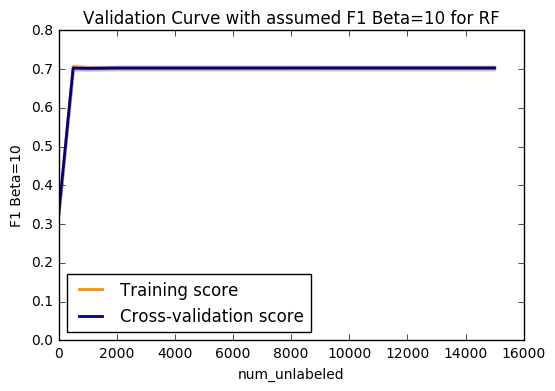

In [13]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with assumed F1 Beta=10 for RF")
plt.xlabel("num_unlabeled")
plt.ylabel("F1 Beta=10")
plt.ylim(0.0, 0.8)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()